## Step 1: Environment Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

# Custom modules
from data_loading import WaferDataLoader
from utility import (
    hyperparameter_tuning,
    kfold_cross_validation,
    train_best_model,
    load_best_model,
    evaluate_model,
    plot_training_history
)
from config import SIMPLE_NN_CONFIG, CNN_CONFIG
from models import SimpleNN  # Import your model classes

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Helper functions defined successfully!
Device: cuda


## Step 2: Load and Preprocess Data

In [2]:
# Load data
loader = WaferDataLoader()
X = loader.X
y = loader.y

# Normalize
X_normalized = (X - X.min()) / (X.max() - X.min())

print(f"Data shape: {X_normalized.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of classes: {len(np.unique(y))}")

Loading dataset from kagglehub cache...
✓ Dataset loaded successfully
  Wafer maps shape: (38015, 52, 52)
  Raw labels shape: (38015, 8)
✓ Labels converted to class indices
  Number of unique defect classes: 38
✓ Dataset loaded successfully
  Wafer maps shape: (38015, 52, 52)
  Raw labels shape: (38015, 8)
✓ Labels converted to class indices
  Number of unique defect classes: 38
Data shape: (38015, 52, 52)
Labels shape: (38015,)
Number of classes: 38
Data shape: (38015, 52, 52)
Labels shape: (38015,)
Number of classes: 38


In [3]:
# Split data: 70% train, 15% val, 15% test
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X_normalized, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Val:   {X_val.shape[0]} samples")
print(f"Test:  {X_test.shape[0]} samples")

Train: 26610 samples
Val:   5702 samples
Test:  5703 samples


## Step 3: Hyperparameter Tuning (Grid Search)

Find optimal hyperparameters using grid search on train/val split.

In [4]:
# Define parameter grid
param_grid = {
    'learning_rate': [0.001],
    'batch_size': [32, 64],
    'optimizer': ['adam']
}

print("\n" + "="*70)
print("PHASE 1: HYPERPARAMETER TUNING".center(70))
print("="*70)

# Run grid search
tuning_results = hyperparameter_tuning(
    SimpleNN,
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    param_grid=param_grid,
    input_size=2704,
    num_classes=38,
    device=device,
    num_epochs=2,  # Moderate epochs for tuning
    patience=5
)

# Display results
print("\nTop 5 Configurations:")
print(tuning_results['summary_df'].head(5))

# Extract best parameters
best_params = tuning_results['best_params']
print(f"\nBest Hyperparameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")
print(f"\nBest Validation Accuracy: {tuning_results['best_val_acc']:.4f}")


                    PHASE 1: HYPERPARAMETER TUNING                    

                  HYPERPARAMETER TUNING: Grid Search                  
Model: SimpleNN
Total combinations to evaluate: 2
Parameters: learning_rate, batch_size, optimizer


[1/2] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/2:
  Train Loss: 2.8631, Train Acc: 0.1821
  Val Loss: 2.4273, Val Acc: 0.2475
  ✓ New best validation loss!


Epoch 2/2:
  Train Loss: 2.2143, Train Acc: 0.3074
  Val Loss: 2.2109, Val Acc: 0.3255
  ✓ New best validation loss!

Loaded best model with validation loss: 2.2109
Train Acc: 0.3074 | Val Acc: 0.3255 | Test Acc: 0.3240
✓ NEW BEST! (Val Acc: 0.3255)

[2/2] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/2:
  Train Loss: 2.9533, Train Acc: 0.1713
  Val Loss: 2.5632, Val Acc: 0.2310
  ✓ New best validation loss!


Epoch 2/2:
  Train Loss: 2.3323, Train Acc: 0.2898
  Val Loss: 2.2422, Val Acc: 0.2929
  ✓ New best validation loss!

Loaded best model with validation loss: 2.2422
Train Acc: 0.2898 | Val Acc: 0.2929 | Test Acc: 0.2877

                        TUNING RESULTS SUMMARY                        

Top 5 Configurations:
 Rank  learning_rate  batch_size optimizer  Train_Acc  Val_Acc  Test_Acc  Epochs  Params
    1          0.001          32      adam   0.307403  0.32550  0.324040       2  102790
    2          0.001          64      adam   0.289778  0.29288  0.287743       2  102790

BEST CONFIGURATION:
  learning_rate: 0.001
  batch_size: 32
  optimizer: adam

Best Validation Accuracy: 0.3255
Test Accuracy (Best Model): 0.3240


Top 5 Configurations:
   Rank  learning_rate  batch_size optimizer  Train_Acc  Val_Acc  Test_Acc  \
0     1          0.001          32      adam   0.307403  0.32550  0.324040   
1     2          0.001          64      adam   0.289778  0.29288  0.287743   

   Epochs  

## Step 4: K-Fold Cross-Validation

Validate best hyperparameters using K-Fold cross-validation on full training data.

In [5]:
# Combine train and val for K-fold
X_full_train = np.concatenate([X_train, X_val], axis=0)
y_full_train = np.concatenate([y_train, y_val], axis=0)

print("\n" + "="*70)
print("PHASE 2: K-FOLD CROSS-VALIDATION".center(70))
print("="*70)

# Run K-Fold CV with best parameters
kfold_results = kfold_cross_validation(
    SimpleNN,
    X_full_train,
    y_full_train,
    param_config=best_params,
    k=5,
    input_size=2704,
    num_classes=38,
    device=device,
    num_epochs=5,
    patience=5
)

print(f"\nCross-Validation Results:")
print(f"Mean Val Accuracy: {kfold_results['mean_val_acc']:.4f} ± {kfold_results['std_val_acc']:.4f}")
print(f"Best Fold: {kfold_results['best_fold'] + 1}")


                   PHASE 2: K-FOLD CROSS-VALIDATION                   

                    K-FOLD CROSS-VALIDATION (k=5)                     
Model: SimpleNN
Learning Rate: 0.001
Batch Size: 32
Optimizer: adam


                               FOLD 1/5                               
Train samples: 25849
Val samples:   6463



Epoch 1/5:
  Train Loss: 2.8687, Train Acc: 0.1793
  Val Loss: 2.4082, Val Acc: 0.2403
  ✓ New best validation loss!


Epoch 2/5:
  Train Loss: 2.2197, Train Acc: 0.3089
  Val Loss: 2.1420, Val Acc: 0.2799
  ✓ New best validation loss!


Epoch 3/5:
  Train Loss: 1.9516, Train Acc: 0.3803
  Val Loss: 2.0140, Val Acc: 0.3624
  ✓ New best validation loss!


Epoch 4/5:
  Train Loss: 1.7668, Train Acc: 0.4463
  Val Loss: 1.8343, Val Acc: 0.3987
  ✓ New best validation loss!


Epoch 5/5:
  Train Loss: 1.6120, Train Acc: 0.5012
  Val Loss: 1.8165, Val Acc: 0.3902
  ✓ New best validation loss!

Loaded best model with validation loss: 1.8165

Fold 1 Results:
  Train Acc: 0.5012
  Val Acc:   0.3902
  Epochs:    5

                               FOLD 2/5                               
Train samples: 25849
Val samples:   6463

Train samples: 25849
Val samples:   6463



Epoch 1/5:
  Train Loss: 2.8691, Train Acc: 0.1809
  Val Loss: 2.4712, Val Acc: 0.2352
  ✓ New best validation loss!


Epoch 2/5:
  Train Loss: 2.2202, Train Acc: 0.3086
  Val Loss: 2.2002, Val Acc: 0.2960
  ✓ New best validation loss!


Epoch 3/5:
  Train Loss: 1.9454, Train Acc: 0.3876
  Val Loss: 2.0240, Val Acc: 0.3197
  ✓ New best validation loss!


Epoch 4/5:
  Train Loss: 1.7601, Train Acc: 0.4432
  Val Loss: 1.9771, Val Acc: 0.3166
  ✓ New best validation loss!


Epoch 5/5:
  Train Loss: 1.6213, Train Acc: 0.4941
  Val Loss: 1.8300, Val Acc: 0.3973
  ✓ New best validation loss!

Loaded best model with validation loss: 1.8300

Fold 2 Results:
  Train Acc: 0.4941
  Val Acc:   0.3973
  Epochs:    5

                               FOLD 3/5                               
Train samples: 25850
Val samples:   6462

Train samples: 25850
Val samples:   6462



Epoch 1/5:
  Train Loss: 2.8778, Train Acc: 0.1807
  Val Loss: 2.3714, Val Acc: 0.2818
  ✓ New best validation loss!


Epoch 2/5:
  Train Loss: 2.2239, Train Acc: 0.3029
  Val Loss: 2.1874, Val Acc: 0.2673
  ✓ New best validation loss!


Epoch 3/5:
  Train Loss: 1.9425, Train Acc: 0.3919
  Val Loss: 2.0092, Val Acc: 0.3415
  ✓ New best validation loss!


Epoch 4/5:
  Train Loss: 1.7658, Train Acc: 0.4417
  Val Loss: 1.9578, Val Acc: 0.3473
  ✓ New best validation loss!


Epoch 5/5:
  Train Loss: 1.6209, Train Acc: 0.4966
  Val Loss: 1.8271, Val Acc: 0.3872
  ✓ New best validation loss!

Loaded best model with validation loss: 1.8271

Fold 3 Results:
  Train Acc: 0.4966
  Val Acc:   0.3872
  Epochs:    5

                               FOLD 4/5                               
Train samples: 25850
Val samples:   6462

Train samples: 25850
Val samples:   6462



Epoch 1/5:
  Train Loss: 2.8674, Train Acc: 0.1806
  Val Loss: 2.3744, Val Acc: 0.2516
  ✓ New best validation loss!


Epoch 2/5:
  Train Loss: 2.2201, Train Acc: 0.3010
  Val Loss: 2.2222, Val Acc: 0.2801
  ✓ New best validation loss!


Epoch 3/5:
  Train Loss: 1.9482, Train Acc: 0.3850
  Val Loss: 1.9963, Val Acc: 0.3559
  ✓ New best validation loss!


Epoch 4/5:
  Train Loss: 1.7715, Train Acc: 0.4429
  Val Loss: 1.8745, Val Acc: 0.3641
  ✓ New best validation loss!


Epoch 5/5:
  Train Loss: 1.6253, Train Acc: 0.4901
  Val Loss: 1.8550, Val Acc: 0.3938
  ✓ New best validation loss!

Loaded best model with validation loss: 1.8550

Fold 4 Results:
  Train Acc: 0.4901
  Val Acc:   0.3938
  Epochs:    5

                               FOLD 5/5                               
Train samples: 25850
Val samples:   6462



Epoch 1/5:
  Train Loss: 2.8701, Train Acc: 0.1792
  Val Loss: 2.4740, Val Acc: 0.2259
  ✓ New best validation loss!


Epoch 2/5:
  Train Loss: 2.2215, Train Acc: 0.3027
  Val Loss: 2.1821, Val Acc: 0.3066
  ✓ New best validation loss!


Epoch 3/5:
  Train Loss: 1.9424, Train Acc: 0.3867
  Val Loss: 2.0246, Val Acc: 0.3138
  ✓ New best validation loss!


Epoch 4/5:
  Train Loss: 1.7694, Train Acc: 0.4462
  Val Loss: 1.8909, Val Acc: 0.3513
  ✓ New best validation loss!


Epoch 5/5:
  Train Loss: 1.6204, Train Acc: 0.4961
  Val Loss: 1.8994, Val Acc: 0.3621
  Patience: 1/5

Loaded best model with validation loss: 1.8909

Fold 5 Results:
  Train Acc: 0.4961
  Val Acc:   0.3621
  Epochs:    5

                   K-FOLD CROSS-VALIDATION RESULTS                    
 Fold  Train_Acc  Val_Acc  Epochs
    1   0.501180 0.390221       5
    2   0.494062 0.397339       5
    3   0.496557 0.387187       5
    4   0.490097 0.393841       5
    5   0.496093 0.362117       5

Mean Train Acc: 0.4956 ± 0.0036
Mean Val Acc:   0.3861 ± 0.0125
Best Fold:      Fold 2 (Val Acc: 0.3973)


Cross-Validation Results:
Mean Val Accuracy: 0.3861 ± 0.0125
Best Fold: 2


## Step 5: Train Final Model with Best Hyperparameters

Train the final model on full train+val set and save to disk.

In [6]:
print("\n" + "="*70)
print("PHASE 3: TRAIN FINAL MODEL".center(70))
print("="*70)

# Train best model on full train+val data
final_model_result = train_best_model(
    SimpleNN,
    X_full_train,  # Use full training data (train + val)
    X_test,        # Use test as validation for monitoring
    X_test,        # Test set for final evaluation
    y_full_train,
    y_test,
    y_test,
    best_params=best_params,
    input_size=2704,
    num_classes=38,
    device=device,
    num_epochs=5,
    patience=7,
    save_path='models/simple_nn_best.pth',  # Save model
    verbose=True
)

print(f"\nFinal Model Performance:")
print(f"  Test Accuracy: {final_model_result['test_acc']:.4f}")
print(f"  Model saved to: {final_model_result['save_path']}")


                      PHASE 3: TRAIN FINAL MODEL                      

                         TRAINING BEST MODEL                          
Model: SimpleNN
Parameters:
  learning_rate: 0.001
  batch_size: 32
  optimizer: adam

Model: SimpleNN
Architecture: 2704 -> 38
Total parameters: 102,790

Model structure:
SimpleNN(
  (fc): Linear(in_features=2704, out_features=38, bias=True)
)

Data Loaders:
  Training batches: 1010 (batch_size=32)
  Validation batches: 179 (batch_size=32)
  Test batches: 179 (batch_size=32)



Epoch 1/5 [Train]:   0%|          | 0/1010 [00:00<?, ?it/s]

Epoch 1/5:
  Train Loss: 2.7777, Train Acc: 0.1946
  Val Loss: 2.3664, Val Acc: 0.2327
  ✓ New best validation loss!


Epoch 2/5:
  Train Loss: 2.1360, Train Acc: 0.3247
  Val Loss: 2.0423, Val Acc: 0.3251
  ✓ New best validation loss!


Epoch 3/5:
  Train Loss: 1.8782, Train Acc: 0.3983
  Val Loss: 1.9827, Val Acc: 0.3337
  ✓ New best validation loss!


Epoch 4/5:
  Train Loss: 1.6858, Train Acc: 0.4683
  Val Loss: 1.8199, Val Acc: 0.3863
  ✓ New best validation loss!


Epoch 5/5:
  Train Loss: 1.5597, Train Acc: 0.5101
  Val Loss: 1.7286, Val Acc: 0.4114
  ✓ New best validation loss!

Loaded best model with validation loss: 1.7286

✓ Model saved to: models/simple_nn_best.pth

                          TRAINING COMPLETE                           
Final Train Accuracy: 0.5101
Final Val Accuracy:   0.4114
Test Accuracy:        0.4114
Epochs Trained:       5


Final Model Performance:
  Test Accuracy: 0.4114
  Model saved to: models/simple_nn_best.pth


## Step 6: Visualize Training History

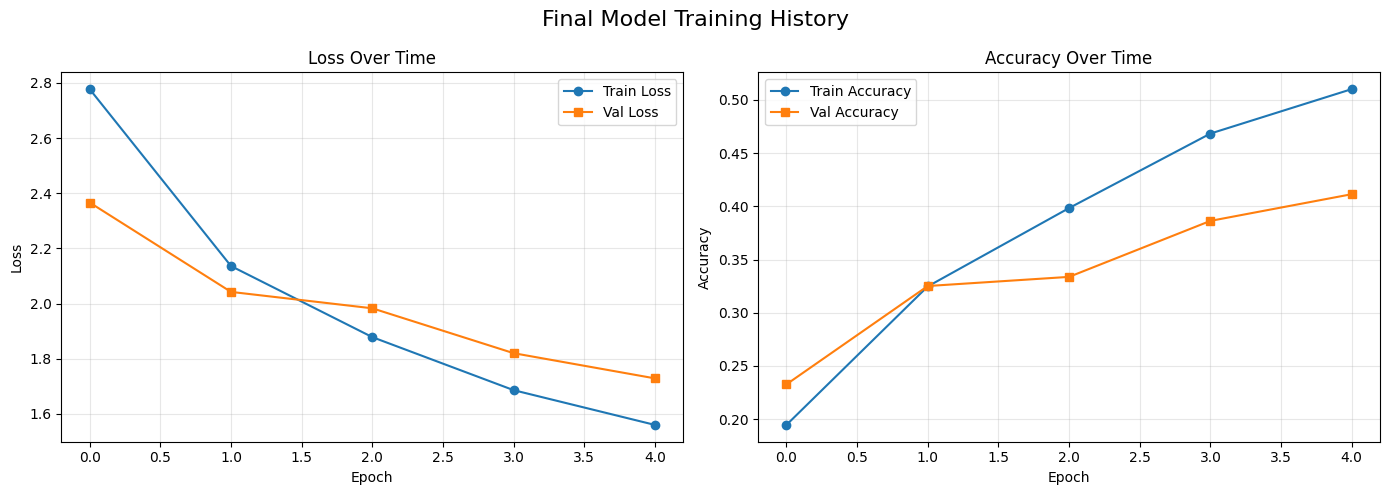

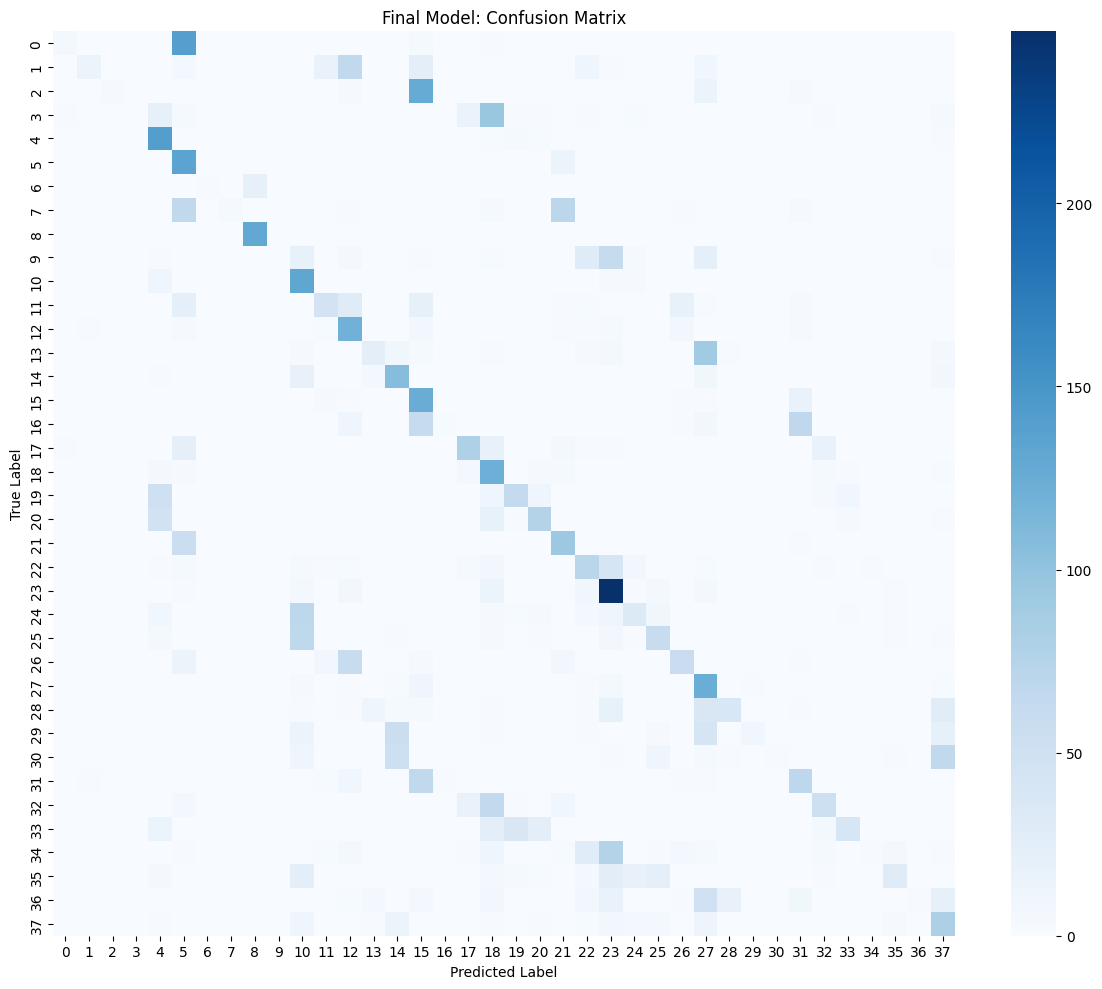

In [7]:
# Plot training history
plot_training_history(
    final_model_result['history'],
    title='Final Model Training History'
)

# Plot confusion matrix
from utility import plot_confusion_matrix
test_labels = final_model_result['test_labels']
test_preds = final_model_result['test_preds']
num_classes = 38
plot_confusion_matrix(test_labels, test_preds, num_classes,
                        "Final Model: Confusion Matrix")


## Step 7: Load Saved Model and Test

Demonstrate loading the saved model for inference.

In [8]:
print("\n" + "="*70)
print("PHASE 4: LOAD AND TEST SAVED MODEL".center(70))
print("="*70)

# Load saved model
loaded_model = load_best_model(
    SimpleNN,
    checkpoint_path='models/simple_nn_best.pth',
    device=device,
    verbose=True
)

# Verify model works
from torch.utils.data import DataLoader, TensorDataset

test_dataset = TensorDataset(
    torch.FloatTensor(X_test),
    torch.LongTensor(y_test)
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate loaded model
test_acc, test_labels, test_preds = evaluate_model(
    loaded_model['model'],
    test_loader,
    device
)

print(f"\nLoaded Model Test Accuracy: {test_acc:.4f}")


                  PHASE 4: LOAD AND TEST SAVED MODEL                  

                            LOADING MODEL                             
Checkpoint: models/simple_nn_best.pth
Model Class: SimpleNN
Input Size: 2704
Num Classes: 38

Hyperparameters:
  learning_rate: 0.001
  batch_size: 32
  optimizer: adam

Performance:
  Train Acc: 0.5101
  Val Acc:   0.4114
  Test Acc:  0.4114


Loaded Model Test Accuracy: 0.4114


c:\Users\akash\OneDrive - University of Florida\wafer\utility.py:647: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=dev

## Step 8: Complete Pipeline Summary

In [9]:
# Create comprehensive summary
summary = {
    'Model': 'SimpleNN',
    'Best Learning Rate': best_params['learning_rate'],
    'Best Batch Size': best_params['batch_size'],
    'Best Optimizer': best_params['optimizer'],
    'Grid Search Val Acc': f"{tuning_results['best_val_acc']:.4f}",
    'K-Fold Mean Val Acc': f"{kfold_results['mean_val_acc']:.4f} ± {kfold_results['std_val_acc']:.4f}",
    'Final Test Acc': f"{final_model_result['test_acc']:.4f}",
    'Model Path': final_model_result['save_path']
}

print("\n" + "="*70)
print("COMPLETE PIPELINE SUMMARY".center(70))
print("="*70)
for key, value in summary.items():
    print(f"{key:25s}: {value}")
print("="*70)


                      COMPLETE PIPELINE SUMMARY                       
Model                    : SimpleNN
Best Learning Rate       : 0.001
Best Batch Size          : 32
Best Optimizer           : adam
Grid Search Val Acc      : 0.3255
K-Fold Mean Val Acc      : 0.3861 ± 0.0125
Final Test Acc           : 0.4114
Model Path               : models/simple_nn_best.pth


---

## Protocol Summary

### Phase 1: Hyperparameter Tuning
- **Method**: Grid search on train/val split
- **Output**: Best hyperparameters based on validation accuracy

### Phase 2: K-Fold Cross-Validation
- **Method**: 5-fold stratified cross-validation
- **Purpose**: Validate robustness of best hyperparameters
- **Output**: Mean ± std validation accuracy across folds

### Phase 3: Train Final Model
- **Method**: Train on full train+val data with best hyperparameters
- **Purpose**: Maximize training data for final model
- **Output**: Trained model saved to disk with test accuracy

### Phase 4: Load and Test
- **Method**: Load saved model from disk
- **Purpose**: Demonstrate model persistence and reusability
- **Output**: Verified test accuracy

---

## Key Functions Used:

| Function | Purpose |
|----------|----------|
| `hyperparameter_tuning()` | Grid search for optimal hyperparameters |
| `kfold_cross_validation()` | K-fold CV to validate hyperparameters |
| `train_best_model()` | Train final model with best params and save |
| `load_best_model()` | Load saved model for inference |
| `evaluate_model()` | Evaluate model on test set |

---

## Best Practices:

1. ✅ **Separate test set**: Never use test data during hyperparameter tuning
2. ✅ **Stratified splits**: Maintain class balance in train/val/test splits
3. ✅ **Cross-validation**: Validate robustness before final training
4. ✅ **Save models**: Always save trained models with hyperparameters
5. ✅ **Reproducibility**: Set random seeds for consistent results